In [1]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import random
import pprint

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import xray
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.sw.info

import rtmtools.rrtmg.sw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.sw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)




<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

# Individual g-points in solar infra-red bands

### Parameters used in solir()

      data xk/
     1  0.0010, 0.0133, 0.0422, 0.1334, 0.4217,
     2  1.334,  5.623,  31.62,  177.8,  1000.0   
     
  
      data hk/
     1 .20673,.08236,.01074,  .03497,.01157,.00360,
     2 .03011,.01133,.00411,  .02260,.01143,.00421,
     3 .01336,.01240,.00389,  .00696,.01258,.00326,
     4 .00441,.01381,.00499,  .00115,.00650,.00465,
     5 .00026,.00244,.00245,  .00000,.00094,.00145/

In [2]:
name_molecule = r'$H_{2}O$'

In [3]:
# Load CRD results

# CRD H2008
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/SW/examples/mls75_H2O/OUTPUT_CRD.dat'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, signed_fluxes = True)


In [4]:
# CRD H2012
pathout_crd = '../crd/SW/examples/mls75_H2O_solzen_60_H2012/OUTPUT_CRD.dat'
pnl_crd_H2012 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, signed_fluxes = True)

In [20]:
# Load CLIRAD results
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/SW/examples/mls75_H2O_solir_gpts//OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, signed_fluxes = True)

In [358]:
# Load AER RRTMG's results
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/SW/examples/mls_71lvls_H2O/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True)

In [3]:

    
def plot_pressure_VS_dTdt_linearlog(ds, whichrate = 'heating_rate', ib = 7):
    
    Nik = 10
    
    srss = [ds[whichrate].sel(ib = ib, ik = ik).to_pandas() for ik in range(1, Nik + 1)]
    names = ['(ib, ik) = ({}, {})'.format(ib, ik) for ik in range(1, Nik + 1)]
        
    #colours, linestyles = zip(*unique_colour_linestyle_pairs(Npairs = Nik))
    colours, linestyles = zip(*viz.matplotlib_colour_linestyle_tuples(N = Nik))
    
    ylabel, xlabel = 'pressure [mbar]', '{} [deg/day]'.format(whichrate)
    title = 'Band {}'.format(ib)
    figsize = (15, 10)
    
    fig = viz.plot_pdseries_indexVSvalues_linearlog(srss = srss,\
                                                names = names,
                                                colours = colours,
                                                linestyles = linestyles,
                                                ylabel = ylabel,
                                                xlabel = xlabel,
                                                figsize = figsize,
                                                title = title)
    return fig
    


In [4]:
def hr_from_pnl_clirad(pnl_clirad, ib = 6):
    '''
    This plots to compare the heating rates from OUTPUT_CLIRAD and solir_gpts
    in shorwave bands 6, 7 and 8 (the solir bands).
    '''
    df = cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl_clirad, wbands = [ib])
    hr = df['heating_rate'][1:]
    
    layer_pressure = .5 * (df['pressure'][: -1].values + df['pressure'][1:].values)
    hr.index = layer_pressure
    return hr




def compare_OUTPUT_CLIRAD_and_solir_gpts(pnl, ds, ib = 6):
    '''
    This plots to compare the heating rates from OUTPUT_CLIRAD and solir_gpts
    in shorwave bands 6, 7 and 8 (the solir bands).
    INPUT:
    pnl --- Pandas Panel from loading OUTPUT_CLIRAD
    ds  --- Xray Dataset from loading solir_gpts
    ib  --- spectral band to compare (6, 7, or 8)
    '''
    Trate = 'heating_rate'
    
    srs_output_clirad = hr_from_pnl_clirad(pnl_clirad, ib = ib)
    srs_solir_gpts = ds[Trate].sel(ib = ib).sum(dim = 'ik').to_pandas()
    
    srss = [srs_solir_gpts, srs_output_clirad]
    names = ['summed outside CLIRAD', 'summed inside CLIRAD']
    colours, linestyles = zip(*unique_colour_linestyle_pairs(Npairs=2))
    ylabel, xlabel = 'pressure [mbar]', '{} [deg/day]'.format(Trate)
    title = 'Band {}'.format(ib)
    
    fig = plot_pdseries_indexVSvalues_linearlog(srss = srss,
                                                names = names,
                                                linestyles = linestyles,
                                                colours = colours,
                                                ylabel = ylabel, xlabel = xlabel, title = title,
                                                figsize = (15, 10))
    return fig

In [5]:
# load output data from OUTPUT_CLIRAD_solir_gpoints.dat

pathout_clirad_solir_gpts = '/nuwa_cluster/home/jackyu/radiation/clirad/SW/examples/mls75_H2O_solir_gpts/OUTPUT_CLIRAD_solir_gpoints.dat'
ds = cliradwrangle.load_clirad_solirgpts(pathout_clirad_solir_gpts)



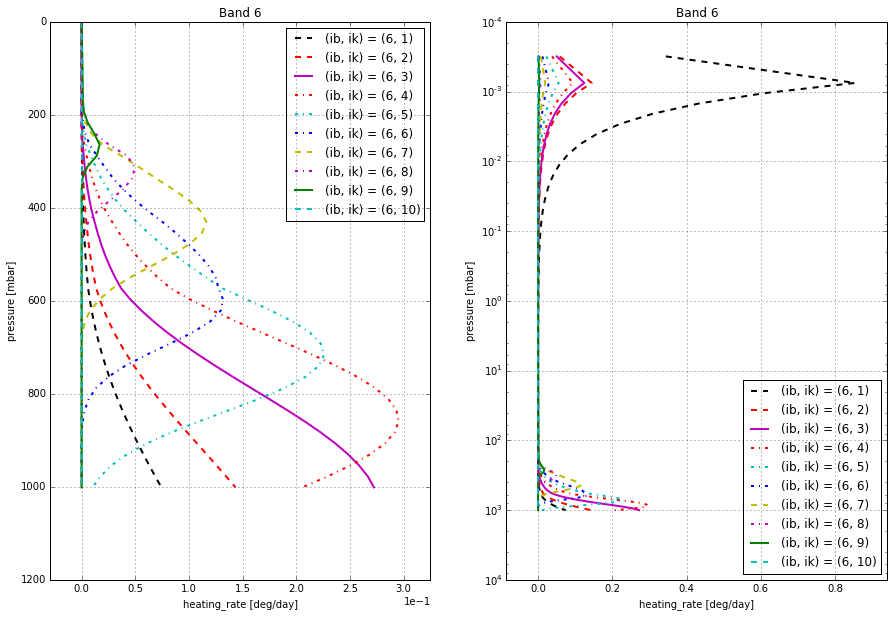

In [6]:
# Heating rate for all g-points.  Band 6

ib = 6
whichrate = 'heating_rate'

fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate = whichrate, ib = ib)

In [7]:
# Total heating rate of Band 6

#fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib = 6)

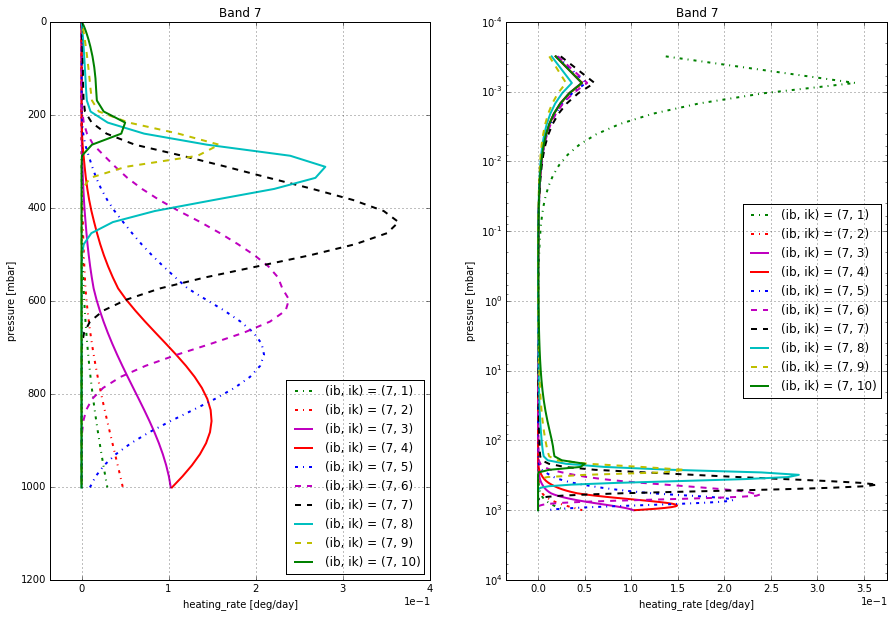

In [8]:
# Heating rate for all g-points.  Band 7

ib = 7
whichrate = 'heating_rate'

fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate = whichrate, ib = ib)

In [9]:
# Total heating rate of Band 7

#fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib = 7)

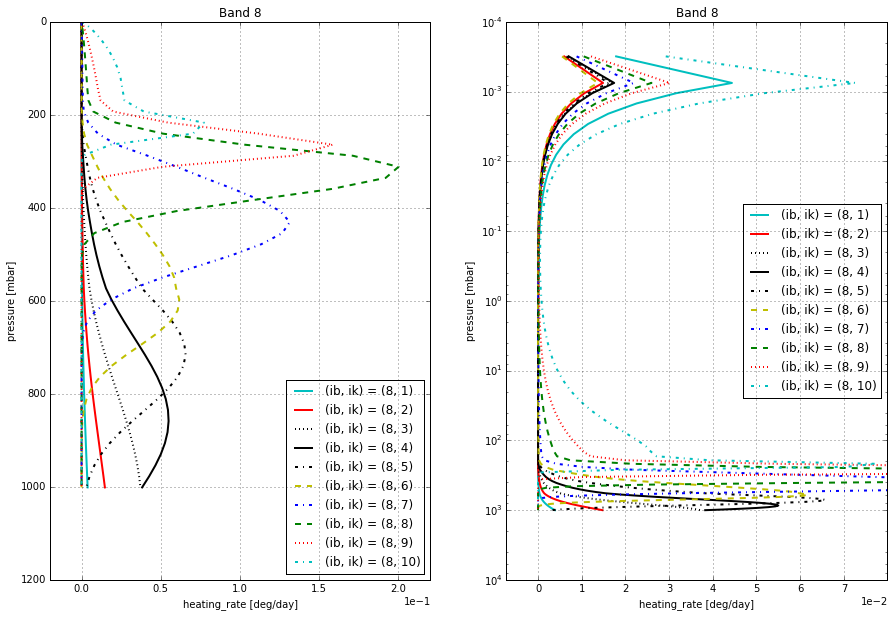

In [10]:
# Heating rate for all g-points.  Band 8

ib = 8
whichrate = 'heating_rate'

fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate = whichrate, ib = ib)

In [11]:
# Total heating rate of Band 8

#fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib = 8)

In [12]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')